In [1]:
!pip install torch==2.0.0+cu118 --index-url https://download.pytorch.org/whl/cu118
!pip install torch_geometric==2.3.1
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install deepsnap

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89990 sha256=9b2c79036629cb703a939448e9c86f9d424836811d6dce61ccd25ad18c255482
  Stored in directory: /root/.cache/pip/wheels/27/2c/b6/3ed2983b1b44fe0dea1bb35234b09f2c22fb8ebb308679c922
Successfully built lit
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0+cu121
    Uninstalling torch-2.4.0+cu121:
      Successfully uninstalled torch-2.4.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.0+cu121 requires torch==2.4.

In [2]:
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn.conv import MessagePassing
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.utils import add_remaining_self_loops
from torch_scatter import scatter_add, scatter
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
import time

In [3]:
class GCNIDConvLayer(MessagePassing):
    def __init__(self,
                 in_channels,
                 out_channels,
                 improved=False,
                 cached=False,
                 bias=True,
                 normalize=True,
                 **kwargs):
        super(GCNIDConvLayer, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.normalize = normalize

        self.weight = Parameter(torch.Tensor(in_channels, out_channels))
        self.weight_id = Parameter(torch.Tensor(in_channels, out_channels))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.weight_id)
        zeros(self.bias)
        self.cached_result = None
        self.cached_num_edges = None

    @staticmethod
    def norm(edge_index,
             num_nodes,
             edge_weight=None,
             improved=False,
             dtype=None):
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1), ),
                                     dtype=dtype,
                                     device=edge_index.device)

        fill_value = 1.0 if not improved else 2.0
        edge_index, edge_weight = add_remaining_self_loops(
            edge_index, edge_weight, fill_value, num_nodes)

        row, col = edge_index
        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

    def forward(self, x, edge_index, id, edge_weight=None):
        x_id = torch.index_select(x, dim=0, index=id)
        x_id = torch.matmul(x_id, self.weight_id)
        x = torch.matmul(x, self.weight)
        x.index_add_(0, id, x_id)

        if self.cached and self.cached_result is not None:
            if edge_index.size(1) != self.cached_num_edges:
                raise RuntimeError(
                    'Cached {} number of edges, but found {}. Please '
                    'disable the caching behavior of this layer by removing '
                    'the `cached=True` argument in its constructor.'.format(
                        self.cached_num_edges, edge_index.size(1)))

        if not self.cached or self.cached_result is None:
            self.cached_num_edges = edge_index.size(1)
            if self.normalize:
                edge_index, norm = self.norm(edge_index, x.size(self.node_dim),
                                             edge_weight, self.improved,
                                             x.dtype)
            else:
                norm = edge_weight
            self.cached_result = edge_index, norm


        edge_index, norm = self.cached_result

        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j if norm is not None else x_j

    def update(self, aggr_out):
        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)
class CRD(nn.Module):
    def __init__(self, dim_in, dim_out, bias=False, p=0.6, **kwargs):
        super(CRD, self).__init__()
        self.conv = GCNIDConvLayer(dim_in, dim_out, bias=bias)
        self.p = p

    def reset_parameters(self):
        self.conv.reset_parameters()

    def forward(self, batch):
        batch.node_feature = F.relu(self.conv(batch.node_feature, batch.edge_index,
                                        batch.node_id_index)) # prelu, swish, leaky relu
        batch.node_feature = F.dropout(batch.node_feature, p=self.p, training=self.training)
        return batch

class CLS(nn.Module):
    def __init__(self, dim_in, dim_out, bias=False, **kwargs):
        super(CLS, self).__init__()
        self.conv = GCNIDConvLayer(dim_in, dim_out, bias=bias)

    def reset_parameters(self):
        self.conv.reset_parameters()

    def forward(self, batch):
        batch.node_feature = self.conv(batch.node_feature, batch.edge_index,
                                        batch.node_id_index)
        batch.node_feature = F.log_softmax(batch.node_feature, dim=1)
        return batch

class GCNIDConv(nn.Module):
    def __init__(self, dim_in, dim_out, bias=False, p=0.6, **kwargs):
        super(GCNIDConv, self).__init__()

        self.p = p

        self.crd = CRD(dim_in, 16, bias=bias, p=p) # 0.0, 0.3, 0.6
        self.cls = CLS(16, dim_out, bias=bias)

    def reset_parameters(self):
        self.crd.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, batch):
        batch = self.crd(batch)
        batch = self.cls(batch)
        return batch

In [4]:
def ego_nets(graph, radius=2):
    # get networks for mini batch node/graph prediction tasks
    # color center
    egos = []
    n = graph.num_nodes
    # A proper deepsnap.G should have nodes indexed from 0 to n-1
    for i in range(n):
        if radius > 4:
            egos.append(graph.G)
        else:
            egos.append(nx.ego_graph(graph.G, i, radius=radius))
    # relabel egos: keep center node ID, relabel other node IDs
    G = graph.G.__class__()
    id_bias = n
    for i in range(len(egos)):
        G.add_node(i, **egos[i].nodes(data=True)[i])
    for i in range(len(egos)):
        keys = list(egos[i].nodes)
        keys.remove(i)
        id_cur = egos[i].number_of_nodes() - 1
        vals = range(id_bias, id_bias + id_cur)
        id_bias += id_cur
        mapping = dict(zip(keys, vals))
        ego = nx.relabel_nodes(egos[i], mapping, copy=True)
        G.add_nodes_from(ego.nodes(data=True))
        G.add_edges_from(ego.edges(data=True))
    graph.G = G
    graph.node_id_index = torch.arange(len(egos))

In [5]:
# Load the Cora dataset and create a DataLoader object
dataset_raw = Planetoid(root='/tmp/Cora', name='Cora')
# dataset_raw = Planetoid(root='/tmp/CiteSeer', name='CiteSeer')
# dataset_raw = Planetoid(root='/tmp/PubMed', name='PubMed')

graphs = GraphDataset.pyg_to_graphs(dataset_raw)

dataset = GraphDataset(graphs, task='node')

datasets = dataset.split(transductive=True,
                                 split_ratio=[0.7, 0.15, 0.15], # 0.8, 0.1, 0.1
                                 shuffle=True)

def transform_after_split(datasets):

    # Dataset transformation after train/val/test split
    # :param dataset: A list of DeepSNAP dataset objects
    # :return: A list of transformed DeepSNAP dataset objects

    for split_dataset in datasets:
            split_dataset.apply_transform(ego_nets,
                                          radius=2,
                                          update_tensor=True,
                                          update_graph=False)
            split_dataset.task = 'node'
    return datasets

datasets = transform_after_split(datasets)

def set_dataset_info(datasets):
    r"""
    Set global dataset information

    Args:
        datasets: List of dataset object

    """
    # get dim_in and dim_out
    try:
        dim_in = datasets[0].num_node_features
    except Exception:
        dim_in = 1
    try:
        dim_out = datasets[0].num_labels
        if 'classification' in 'classification_multi' and \
                dim_out == 2:
            dim_out = 1
    except Exception:
        dim_out = 1

    # count number of dataset splits
    num_splits = len(datasets)

    return dim_in, dim_out, num_splits

dim_in, dim_out, num_splits = set_dataset_info(datasets)

def create_loader(datasets):
    loader_train = DataLoader(datasets[0],
                              collate_fn=Batch.collate(),
                              batch_size=32, # 16, 64
                              shuffle=True,
                              num_workers=0,
                              pin_memory=False)

    loaders = [loader_train]
    for i in range(1, len(datasets)):
        loaders.append(
            DataLoader(datasets[i],
                       collate_fn=Batch.collate(),
                       batch_size=32, # 16, 64
                       shuffle=False,
                       num_workers=0,
                       pin_memory=False))

    return loaders

loaders = create_loader(datasets)

Processing...
Done!


In [6]:
# Define the device to use for computation (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    torch.cuda.synchronize()

# Create an instance of the model and move it to the device
model = GCNIDConv(dim_in, dim_out).to(device)
model.reset_parameters()

# Define the loss function as cross entropy and move it to the device
# criterion = nn.CrossEntropyLoss().to(device)
criterion = F.nll_loss

In [7]:
class KFAC(Optimizer):

    def __init__(self, net, eps, sua=False, pi=False, update_freq=1,
                 alpha=1.0, constraint_norm=False):
        """ K-FAC Preconditionner for Linear and Conv2d layers.
        Computes the K-FAC of the second moment of the gradients.
        It works for Linear and Conv2d layers and silently skip other layers.
        Args:
            net (torch.nn.Module): Network to precondition.
            eps (float): Tikhonov regularization parameter for the inverses.
            sua (bool): Applies SUA approximation.
            pi (bool): Computes pi correction for Tikhonov regularization.
            update_freq (int): Perform inverses every update_freq updates.
            alpha (float): Running average parameter (if == 1, no r. ave.).
            constraint_norm (bool): Scale the gradients by the squared
                fisher norm.
        """
        self.eps = eps
        self.sua = sua
        self.pi = pi
        self.update_freq = update_freq
        self.alpha = alpha
        self.constraint_norm = constraint_norm
        self.params = []
        self._fwd_handles = []
        self._bwd_handles = []
        self._iteration_counter = 0

        for mod in net.modules():
            mod_name = mod.__class__.__name__
            if mod_name in ['CRD', 'CLS']:
                handle = mod.register_forward_pre_hook(self._save_input)
                self._fwd_handles.append(handle)

                for sub_mod in mod.modules():
                    i_sub_mod = 0
                    if hasattr(sub_mod, 'weight'):
                        assert i_sub_mod == 0
                        # handle = sub_mod.register_backward_hook(self._save_grad_output)
                        handle = sub_mod.register_full_backward_hook(self._save_grad_output)
                        self._bwd_handles.append(handle)

                        params = [sub_mod.weight]
                        if sub_mod.bias is not None:
                            params.append(sub_mod.bias)

                        d = {'params': params, 'mod': mod, 'sub_mod': sub_mod}
                        self.params.append(d)
                        i_sub_mod += 1

        super(KFAC, self).__init__(self.params, {})

    def step(self, update_stats=True, update_params=True, lam=0.):
        """Performs one step of preconditioning."""
        self.lam = lam
        fisher_norm = 0.
        for group in self.param_groups:

            if len(group['params']) == 2:
                weight, bias = group['params']
            else:
                weight = group['params'][0]
                bias = None
            state = self.state[weight]

            # Update convariances and inverses
            if update_stats:
                if self._iteration_counter % self.update_freq == 0:
                    self._compute_covs(group, state)
                    ixxt, iggt = self._inv_covs(state['xxt'], state['ggt'],
                                                state['num_locations'])
                    state['ixxt'] = ixxt
                    state['iggt'] = iggt
                else:
                    if self.alpha != 1:
                        self._compute_covs(group, state)

            if update_params:
                gw, gb = self._precond(weight, bias, group, state)

                # Updating gradients
                if self.constraint_norm:
                    fisher_norm += (weight.grad * gw).sum()

                weight.grad.data = gw
                if bias is not None:
                    if self.constraint_norm:
                        fisher_norm += (bias.grad * gb).sum()
                    bias.grad.data = gb

            # Cleaning
            if 'x' in self.state[group['mod']]:
                del self.state[group['mod']]['x']
            if 'gy' in self.state[group['mod']]:
                del self.state[group['mod']]['gy']

        # Eventually scale the norm of the gradients
        if update_params and self.constraint_norm:
            scale = (1. / fisher_norm) ** 0.5
            for group in self.param_groups:
                for param in group['params']:
                    print(param.shape, param)
                    param.grad.data *= scale

        if update_stats:
            self._iteration_counter += 1

    def _save_input(self, mod, i):
        """Saves input of layer to compute covariance."""
        # i = (x, edge_index)
        if mod.training:
            self.state[mod]['x'] = i[0]['node_feature'] #

            # self.mask = i[-1]

    def _save_grad_output(self, mod, grad_input, grad_output):
        """Saves grad on output of layer to compute covariance."""
        if mod.training:

            self.state[mod]['gy'] = grad_output[0] * grad_output[0].size(1)

            self.cached_result = mod.cached_result



    def _precond(self, weight, bias, group, state):
        """Applies preconditioning."""
        ixxt = state['ixxt'] # [d_in x d_in]
        iggt = state['iggt'] # [d_out x d_out]
        g = weight.grad.data # [d_in x d_out]
        s = g.shape

        g = g.contiguous().view(-1, g.shape[-1])

        if bias is not None:
            gb = bias.grad.data
            g = torch.cat([g, gb.view(1, gb.shape[0])], dim=0)

        g = torch.mm(ixxt, torch.mm(g, iggt))

        if bias is not None:
            gb = g[-1].contiguous().view(*bias.shape)
            g = g[:-1]
        else:
            gb = None
        g = g.contiguous().view(*s)
        return g, gb

    def _compute_covs(self, group, state):
        """Computes the covariances."""
        sub_mod = group['sub_mod']
        x = self.state[group['mod']]['x'] # [n x d_in] #
        gy = self.state[group['sub_mod']]['gy'] # [n x d_out] #

        edge_index, edge_weight = self.cached_result # [2, n_edges], [n_edges] #

        # n = float(self.mask.sum() + self.lam*((~self.mask).sum()))
        n = float(x.shape[0])

        x = scatter(x[edge_index[0]]*edge_weight[:, None], edge_index[1], dim=0)

        x = x.data.t()

        if sub_mod.weight.ndim == 3:
            x = x.repeat(sub_mod.weight.shape[0], 1)



        if sub_mod.bias is not None:
            ones = torch.ones_like(x[:1])
            x = torch.cat([x, ones], dim=0)

        if self._iteration_counter == 0:
            state['xxt'] = torch.mm(x, x.t()) / n
        else:
            state['xxt'].addmm_(mat1=x, mat2=x.t(),
                                beta=(1. - self.alpha),
                                alpha=self.alpha / n) #

        gy = gy.data.t() # [d_out x n]

        state['num_locations'] = 1
        if self._iteration_counter == 0:
            state['ggt'] = torch.mm(gy, gy.t()) / n
        else:
            state['ggt'].addmm_(mat1=gy, mat2=gy.t(),
                                beta=(1. - self.alpha),
                                alpha=self.alpha / n)

    def _inv_covs(self, xxt, ggt, num_locations):
        """Inverses the covariances."""
        # Computes pi
        pi = 1.0
        if self.pi:
            tx = torch.trace(xxt) * ggt.shape[0]
            tg = torch.trace(ggt) * xxt.shape[0]
            pi = (tx / tg)
        # Regularizes and inverse
        eps = self.eps / num_locations
        diag_xxt = xxt.new(xxt.shape[0]).fill_((eps * pi) ** 0.5)
        diag_ggt = ggt.new(ggt.shape[0]).fill_((eps / pi) ** 0.5)
        ixxt = (xxt + torch.diag(diag_xxt)).inverse()
        iggt = (ggt + torch.diag(diag_ggt)).inverse()

        return ixxt, iggt

    def __del__(self):
        for handle in self._fwd_handles + self._bwd_handles:
            handle.remove()

In [8]:
preconditioner = KFAC(
    model,  # Pass the model instance
    eps=0.01,  # Set the epsilon value
    sua=False,
    pi=False,
    update_freq=25,
    alpha=1.0,
    constraint_norm=False
)

In [9]:
# Define the optimizer as Adam with learning rate and weight decay
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) # 0.001, 0.1 # 0.0005
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # 0.001, 0.1
# Define a learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [10]:
# Define a function to compute the accuracy of the model predictions
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# Define a function to train the model for one epoch
def train(model, loader, optimizer, criterion, preconditioner=None, lam=0.):
    model.train()
    loss_all = 0
    acc_all = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output.node_feature.index_select(0, data.node_label_index)
        y = data.node_label.index_select(0, data.node_label_index)
        y.requires_grad = False
        loss = criterion(output, y)
        loss.backward(retain_graph=True)

        loss_all += data.num_graphs * loss.item()

        acc_all += accuracy(output, y).item() * data.num_graphs
        preconditioner.step(lam=lam)
        optimizer.step()
    return loss_all / len(loader.dataset), acc_all / len(loader.dataset)

# Define a function to evaluate the model on validation or test set
def eval(model, loader, criterion):
    model.eval()
    loss_all = 0
    acc_all = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            output = output.node_feature.index_select(0, data.node_label_index)
            y = data.node_label.index_select(0, data.node_label_index)
            loss = criterion(output, y)
            loss_all += data.num_graphs * loss.item()
            acc_all += accuracy(output, y).item() * data.num_graphs
    return loss_all / len(loader.dataset), acc_all / len(loader.dataset)

# Define the number of epochs to train the model
num_epochs = 100 # 200, 400

# Create lists to store the training, validation and testing losses and accuracies
train_losses = []
train_accs = []
val_losses = []
val_accs = []
test_losses = []
test_accs = []

start_time = time.time()

# Train the model for num_epochs epochs and evaluate it after each epoch
for epoch in range(num_epochs):
    # lam = (float(epoch)/float(num_epochs))**0.1
    train_loss, train_acc = train(model, loaders[0], optimizer, criterion, preconditioner, lam=0.) #
    val_loss, val_acc = eval(model, loaders[1], criterion)
    test_loss, test_acc = eval(model, loaders[2], criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    scheduler.step()
    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch: 1, Train Loss: 1.9501, Train Acc: 0.1383, Val Loss: 1.8158, Val Acc: 0.4163, Test Loss: 1.8226, Test Acc: 0.4251
Epoch: 2, Train Loss: 1.8050, Train Acc: 0.4174, Val Loss: 1.7062, Val Acc: 0.4803, Test Loss: 1.7157, Test Acc: 0.4865
Epoch: 3, Train Loss: 1.6978, Train Acc: 0.4628, Val Loss: 1.5968, Val Acc: 0.5246, Test Loss: 1.6070, Test Acc: 0.5356
Epoch: 4, Train Loss: 1.5870, Train Acc: 0.5003, Val Loss: 1.4901, Val Acc: 0.5764, Test Loss: 1.4990, Test Acc: 0.5774
Epoch: 5, Train Loss: 1.4723, Train Acc: 0.5462, Val Loss: 1.3855, Val Acc: 0.6108, Test Loss: 1.3925, Test Acc: 0.6388
Epoch: 6, Train Loss: 1.3615, Train Acc: 0.5799, Val Loss: 1.2825, Val Acc: 0.6773, Test Loss: 1.2881, Test Acc: 0.6781
Epoch: 7, Train Loss: 1.2504, Train Acc: 0.6417, Val Loss: 1.1818, Val Acc: 0.7463, Test Loss: 1.1870, Test Acc: 0.7346
Epoch: 8, Train Loss: 1.1587, Train Acc: 0.6770, Val Loss: 1.0856, Val Acc: 0.8054, Test Loss: 1.0899, Test Acc: 0.7887
Epoch: 9, Train Loss: 1.0677, Train Acc:

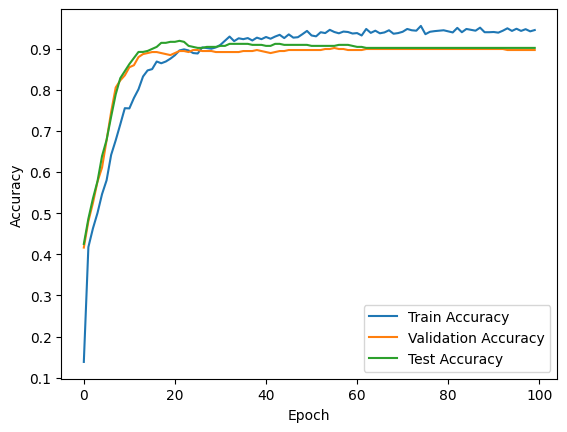

In [11]:
# Plot training, validation, and test accuracy per epoch
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

In [12]:
def params_count(model):
    # Computes the number of parameters.

    # Args:
        # model (nn.Module): PyTorch model

    return sum([p.numel() for p in model.parameters()])


print(params_count(model))

46080
